In [16]:
import os
from pathlib import Path

# Rutas
DATASET_ROOT = "/kaggle/input/data-final/Data"
TRAIN_IMG_DIR = os.path.join(DATASET_ROOT, "train/images")
TRAIN_LBL_DIR = os.path.join(DATASET_ROOT, "train/labels")
VAL_IMG_DIR = os.path.join(DATASET_ROOT, "valid/images")
VAL_LBL_DIR = os.path.join(DATASET_ROOT, "valid/labels")

EXPERIMENT_ROOT = "/kaggle/working/Faster_Experiments"
os.makedirs(EXPERIMENT_ROOT, exist_ok=True)

NUM_CLASSES = 5  # 4 clases + fondo
NUM_TEST_IMAGES = 5  # ← SOLO 5 IMÁGENES PARA PRUEBA

# Crear carpeta de experimentos
os.makedirs(YOLO_ROOT, exist_ok=True)

print("📁 Dataset montado en:", DATA_ROOT)

print("📂 YOLO_ROOT creado en:", YOLO_ROOT)

# Verificar estructura
print("\n📂 Contenido dataset:")
for item in os.listdir(DATA_ROOT):
    item_path = os.path.join(DATA_ROOT, item)
    if os.path.isdir(item_path):
        img_count = len(os.listdir(os.path.join(item_path, "images")))
        print(f"  📁 {item}/ ({img_count} imágenes)")
    else:
        print(f"  📄 {item}")

📁 Dataset montado en: /kaggle/input/data-final/Data
📂 YOLO_ROOT creado en: /kaggle/working/Faster_Experiments

📂 Contenido dataset:
  📄 data.yaml
  📁 valid/ (150 imágenes)
  📁 test/ (134 imágenes)
  📁 train/ (7771 imágenes)


In [5]:
!pip install optuna --quiet

# PyCOCOTools para métricas de detección de objetos
!pip install pycocotools --quiet

# OpenCV y Matplotlib
!pip install opencv-python matplotlib --quiet


In [27]:
pip install torchmetrics


Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import json

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

import cv2
import matplotlib.pyplot as plt

import optuna

In [8]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", DEVICE)

Device: cuda


In [9]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class PreloadedDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, img_size=512):
        self.img_dir = img_dir
        self.lbl_dir = lbl_dir
        self.img_size = img_size

        self.img_files = sorted([
            f for f in os.listdir(img_dir)
            if f.lower().endswith((".jpg", ".png"))
        ])

        if len(self.img_files) == 0:
            raise RuntimeError("No hay imágenes en el directorio")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]

        img_path = os.path.join(self.img_dir, img_name)
        lbl_path = os.path.join(self.lbl_dir, img_name.rsplit(".", 1)[0] + ".txt")

        # -------- Imagen --------
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = cv2.resize(img, (self.img_size, self.img_size))
        h, w = self.img_size, self.img_size

        img_tensor = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0

        # -------- Labels --------
        boxes, labels = self.load_yolo_labels(lbl_path, w, h)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        return img_tensor, target

    def load_yolo_labels(self, path, w, h):
        boxes = []
        labels = []

        if not os.path.exists(path):
            return (
                torch.zeros((0, 4), dtype=torch.float32),
                torch.zeros((0,), dtype=torch.int64)
            )

        with open(path) as f:
            for line in f:
                parts = line.strip().split()
                cls = int(float(parts[0]))
                x, y, bw, bh = map(float, parts[1:])

                x1 = (x - bw / 2) * w
                y1 = (y - bh / 2) * h
                x2 = (x + bw / 2) * w
                y2 = (y + bh / 2) * h

                boxes.append([x1, y1, x2, y2])
                labels.append(cls + 1)

        if len(boxes) == 0:
            return (
                torch.zeros((0, 4), dtype=torch.float32),
                torch.zeros((0,), dtype=torch.int64)
            )

        return (
            torch.tensor(boxes, dtype=torch.float32),
            torch.tensor(labels, dtype=torch.int64)
        )


In [50]:
# mAP como en COCO
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def compute_map_coco(model, data_loader, device):
    model.eval()

    metric = MeanAveragePrecision(
        iou_type="bbox",
        iou_thresholds=None  # usa 0.50:0.95 por defecto (COCO)
    )

    with torch.no_grad():
        for imgs, targets in data_loader:
            imgs = [img.to(device) for img in imgs]
            outputs = model(imgs)

            preds = []
            gts = []

            for o, t in zip(outputs, targets):
                preds.append({
                    "boxes": o["boxes"].detach().cpu(),
                    "scores": o["scores"].detach().cpu(),
                    "labels": o["labels"].detach().cpu(),
                })

                gts.append({
                    "boxes": t["boxes"].detach().cpu(),
                    "labels": t["labels"].detach().cpu(),
                })

            metric.update(preds, gts)

    result = metric.compute()

    return {
        "map50": result["map_50"].item(),
        "map50_95": result["map"].item(),
        "map_per_class": result["map_per_class"].tolist()
    }


In [31]:
train_dataset = PreloadedDataset(TRAIN_IMG_DIR, TRAIN_LBL_DIR, img_size=512)
val_dataset   = PreloadedDataset(VAL_IMG_DIR, VAL_LBL_DIR, img_size=512)

# Protección mínima
if len(train_dataset) == 0:
    raise RuntimeError("Train dataset vacío")

if len(val_dataset) == 0:
    print("Warning: Validation dataset vacío")


In [32]:
img, target = train_dataset[0]
print(target["boxes"].shape)
print(target["labels"])
print(target["labels"].min(), target["labels"].max())


torch.Size([15, 4])
tensor([2, 2, 2, 2, 2, 1, 2, 1, 1, 3, 3, 3, 3, 3, 3])
tensor(1) tensor(3)


In [54]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-3, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW"])

    batch_size = 4
    epochs = 6

    trial_dir = os.path.join(EXPERIMENT_ROOT, f"trial_{trial.number}")
    os.makedirs(trial_dir, exist_ok=True)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=0,
        pin_memory=False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=0,
        pin_memory=False
    )

    model = fasterrcnn_mobilenet_v3_large_fpn(
      weights="DEFAULT",
      min_size=512,   # para no subir tanto la resolución interna
      max_size=800
    )

    # Congelar backbone
    for p in model.backbone.parameters():
        p.requires_grad = False

    # Reemplaza box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features,
        NUM_CLASSES,
    ) 
    
    model.to(DEVICE)

    params = [p for p in model.parameters() if p.requires_grad]

    optimizer = (
        torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
        if optimizer_name == "Adam"
        else torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    )

    epoch_losses = []

    # =========================
    # ENTRENAMIENTO
    # =========================
    for epoch in range(1, epochs + 1):
        print(f"\n===== EPOCH {epoch}/{epochs} =====")
        model.train()  # FORZAR TRAIN MODE
        total_loss = 0.0

        for batch_i, (imgs, targets) in enumerate(train_loader):
            print(f"Batch {batch_i+1}/{len(train_loader)}")

            imgs = [img.to(DEVICE) for img in imgs]

            targets = [
                {
                    "boxes": t["boxes"].to(DEVICE).float(),
                    "labels": t["labels"].to(DEVICE).long()
                }
                for t in targets
            ]

            optimizer.zero_grad(set_to_none=True)
            output = model(imgs, targets)

            # PROTECCIÓN CLAVE
            if isinstance(output, list):
                # Esto NO debería pasar → dataset inválido
                raise RuntimeError(
                    "El modelo devolvió predicciones en vez de pérdidas. "
                    "Revisa que los targets estén bien formados."
                )

            losses = sum(output.values())
            losses.backward()
            optimizer.step()

            total_loss += losses.item()

            del imgs, targets, output, losses  # ayuda al GC si vas justo de VRAM

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)

        # =========================
        # mAP + PRUNING
        # =========================
        if epoch % 2 == 0:
            #map50, map50_95 = compute_map50_95(
                #model, val_loader, DEVICE
            #)

            
            metrics = compute_map_coco(model, val_loader, DEVICE)

            map50 = metrics["map50"]
            map50_95 = metrics["map50_95"]

            

            # ← AQUÍ AGREGAS EL PRINT:
            print(f"DEBUG Epoch {epoch}: map50={map50:.4f}, map50_95={map50_95:.4f}")

            if epoch >= 4:
                trial.report(1 - map50, epoch)  
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()

    # =========================
    # GUARDAR RESULTADOS
    # =========================
    with open(os.path.join(trial_dir, "losses.json"), "w") as f:
        json.dump(epoch_losses, f, indent=4)

    #map50, map50_95 = compute_map50_95(
        #model, val_loader, DEVICE
    #)

    metrics = compute_map_coco(model, val_loader, DEVICE)

    # DEBUG
    print(f"DEBUG FINAL Trial {trial.number}: map50={map50:.4f}, map50_95={map50_95:.4f}")

    with open(os.path.join(trial_dir, "metrics.json"), "w") as f:
        json.dump(
            {
                "map50":  metrics["map50"],
                "map50_95":  metrics["map50_95"],
                "map_per_class": metrics["map_per_class"],
                "lr": lr,
                "weight_decay": weight_decay,
                "optimizer": optimizer_name
            },
            f,
            indent=4
        )

    torch.save(
        model.state_dict(),
        os.path.join(trial_dir, "model.pth")
    )

    return 1 - map50 

In [55]:
# Crear estudio con Successive Halving Pruner
pruner = optuna.pruners.SuccessiveHalvingPruner()
study = optuna.create_study(direction="minimize", pruner=pruner)

# Ejecutar Optuna
study.optimize(objective, n_trials=4)

print("Mejor configuración encontrada:")
print(study.best_params)

[I 2026-01-25 01:58:04,536] A new study created in memory with name: no-name-efc31b7c-3b83-4607-bf30-1e0c7a3cb24d



===== EPOCH 1/6 =====
Batch 1/1943
Batch 2/1943
Batch 3/1943
Batch 4/1943
Batch 5/1943
Batch 6/1943
Batch 7/1943
Batch 8/1943
Batch 9/1943
Batch 10/1943
Batch 11/1943
Batch 12/1943
Batch 13/1943
Batch 14/1943
Batch 15/1943
Batch 16/1943
Batch 17/1943
Batch 18/1943
Batch 19/1943
Batch 20/1943
Batch 21/1943
Batch 22/1943
Batch 23/1943
Batch 24/1943
Batch 25/1943
Batch 26/1943
Batch 27/1943
Batch 28/1943
Batch 29/1943
Batch 30/1943
Batch 31/1943
Batch 32/1943
Batch 33/1943
Batch 34/1943
Batch 35/1943
Batch 36/1943
Batch 37/1943
Batch 38/1943
Batch 39/1943
Batch 40/1943
Batch 41/1943
Batch 42/1943
Batch 43/1943
Batch 44/1943
Batch 45/1943
Batch 46/1943
Batch 47/1943
Batch 48/1943
Batch 49/1943
Batch 50/1943
Batch 51/1943
Batch 52/1943
Batch 53/1943
Batch 54/1943
Batch 55/1943
Batch 56/1943
Batch 57/1943
Batch 58/1943
Batch 59/1943
Batch 60/1943
Batch 61/1943
Batch 62/1943
Batch 63/1943
Batch 64/1943
Batch 65/1943
Batch 66/1943
Batch 67/1943
Batch 68/1943
Batch 69/1943
Batch 70/1943
Batch 

[I 2026-01-25 02:17:00,802] Trial 0 finished with value: 0.7714377194643021 and parameters: {'lr': 0.002915555868694965, 'weight_decay': 3.5788264605059974e-05, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7714377194643021.


DEBUG FINAL Trial 0: map50=0.2286, map50_95=0.0842

===== EPOCH 1/6 =====
Batch 1/1943
Batch 2/1943
Batch 3/1943
Batch 4/1943
Batch 5/1943
Batch 6/1943
Batch 7/1943
Batch 8/1943
Batch 9/1943
Batch 10/1943
Batch 11/1943
Batch 12/1943
Batch 13/1943
Batch 14/1943
Batch 15/1943
Batch 16/1943
Batch 17/1943
Batch 18/1943
Batch 19/1943
Batch 20/1943
Batch 21/1943
Batch 22/1943
Batch 23/1943
Batch 24/1943
Batch 25/1943
Batch 26/1943
Batch 27/1943
Batch 28/1943
Batch 29/1943
Batch 30/1943
Batch 31/1943
Batch 32/1943
Batch 33/1943
Batch 34/1943
Batch 35/1943
Batch 36/1943
Batch 37/1943
Batch 38/1943
Batch 39/1943
Batch 40/1943
Batch 41/1943
Batch 42/1943
Batch 43/1943
Batch 44/1943
Batch 45/1943
Batch 46/1943
Batch 47/1943
Batch 48/1943
Batch 49/1943
Batch 50/1943
Batch 51/1943
Batch 52/1943
Batch 53/1943
Batch 54/1943
Batch 55/1943
Batch 56/1943
Batch 57/1943
Batch 58/1943
Batch 59/1943
Batch 60/1943
Batch 61/1943
Batch 62/1943
Batch 63/1943
Batch 64/1943
Batch 65/1943
Batch 66/1943
Batch 67/19

[I 2026-01-25 02:35:55,357] Trial 1 finished with value: 0.6785753965377808 and parameters: {'lr': 0.0010409383770518521, 'weight_decay': 7.683590751969013e-05, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.6785753965377808.


DEBUG FINAL Trial 1: map50=0.3214, map50_95=0.1398

===== EPOCH 1/6 =====
Batch 1/1943
Batch 2/1943
Batch 3/1943
Batch 4/1943
Batch 5/1943
Batch 6/1943
Batch 7/1943
Batch 8/1943
Batch 9/1943
Batch 10/1943
Batch 11/1943
Batch 12/1943
Batch 13/1943
Batch 14/1943
Batch 15/1943
Batch 16/1943
Batch 17/1943
Batch 18/1943
Batch 19/1943
Batch 20/1943
Batch 21/1943
Batch 22/1943
Batch 23/1943
Batch 24/1943
Batch 25/1943
Batch 26/1943
Batch 27/1943
Batch 28/1943
Batch 29/1943
Batch 30/1943
Batch 31/1943
Batch 32/1943
Batch 33/1943
Batch 34/1943
Batch 35/1943
Batch 36/1943
Batch 37/1943
Batch 38/1943
Batch 39/1943
Batch 40/1943
Batch 41/1943
Batch 42/1943
Batch 43/1943
Batch 44/1943
Batch 45/1943
Batch 46/1943
Batch 47/1943
Batch 48/1943
Batch 49/1943
Batch 50/1943
Batch 51/1943
Batch 52/1943
Batch 53/1943
Batch 54/1943
Batch 55/1943
Batch 56/1943
Batch 57/1943
Batch 58/1943
Batch 59/1943
Batch 60/1943
Batch 61/1943
Batch 62/1943
Batch 63/1943
Batch 64/1943
Batch 65/1943
Batch 66/1943
Batch 67/19

[I 2026-01-25 02:48:32,551] Trial 2 pruned. 


DEBUG Epoch 4: map50=0.0013, map50_95=0.0002

===== EPOCH 1/6 =====
Batch 1/1943
Batch 2/1943
Batch 3/1943
Batch 4/1943
Batch 5/1943
Batch 6/1943
Batch 7/1943
Batch 8/1943
Batch 9/1943
Batch 10/1943
Batch 11/1943
Batch 12/1943
Batch 13/1943
Batch 14/1943
Batch 15/1943
Batch 16/1943
Batch 17/1943
Batch 18/1943
Batch 19/1943
Batch 20/1943
Batch 21/1943
Batch 22/1943
Batch 23/1943
Batch 24/1943
Batch 25/1943
Batch 26/1943
Batch 27/1943
Batch 28/1943
Batch 29/1943
Batch 30/1943
Batch 31/1943
Batch 32/1943
Batch 33/1943
Batch 34/1943
Batch 35/1943
Batch 36/1943
Batch 37/1943
Batch 38/1943
Batch 39/1943
Batch 40/1943
Batch 41/1943
Batch 42/1943
Batch 43/1943
Batch 44/1943
Batch 45/1943
Batch 46/1943
Batch 47/1943
Batch 48/1943
Batch 49/1943
Batch 50/1943
Batch 51/1943
Batch 52/1943
Batch 53/1943
Batch 54/1943
Batch 55/1943
Batch 56/1943
Batch 57/1943
Batch 58/1943
Batch 59/1943
Batch 60/1943
Batch 61/1943
Batch 62/1943
Batch 63/1943
Batch 64/1943
Batch 65/1943
Batch 66/1943
Batch 67/1943
Bat

[I 2026-01-25 03:01:00,903] Trial 3 pruned. 


DEBUG Epoch 4: map50=0.2725, map50_95=0.1092
Mejor configuración encontrada:
{'lr': 0.0010409383770518521, 'weight_decay': 7.683590751969013e-05, 'optimizer': 'Adam'}


In [58]:
# Obtener el mejor trial
best_trial_number = study.best_trial.number

best_model_dir = os.path.join(EXPERIMENT_ROOT, f"trial_{best_trial_number}")

print(f"El mejor trial es trial_{best_trial_number} con los siguientes hiperparámetros:")
print(study.best_params)


El mejor trial es trial_1 con los siguientes hiperparámetros:
{'lr': 0.0010409383770518521, 'weight_decay': 7.683590751969013e-05, 'optimizer': 'Adam'}


In [59]:
# Cargar el modelo entrenado del mejor trial
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
import torch

# Inicializar el modelo con la misma arquitectura
model = fasterrcnn_mobilenet_v3_large_fpn(weights=None, min_size=512,
    max_size=800)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features,
        NUM_CLASSES
    )

model.to(DEVICE)

# Cargar los pesos del mejor trial
model.load_state_dict(torch.load(os.path.join(best_model_dir, "model.pth")))
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(512,), max_size=800, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [60]:
# Evaluar en validación
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

map50, map50_95 = compute_map50_95(model, val_loader, DEVICE)

print(f"Mejor modelo - mAP@0.5: {map50:.4f}")
print(f"Mejor modelo - mAP@0.5:0.95: {map50_95:.4f}")


Mejor modelo - mAP@0.5: 0.3851
Mejor modelo - mAP@0.5:0.95: 0.2503


=== MÉTRICAS POR CLASE ===
door      : P=0.665, R=0.936, F1=0.777
window    : P=0.986, R=0.921, F1=0.952
balcony   : P=1.000, R=0.962, F1=0.980
railing   : P=0.853, R=0.906, F1=0.879

Total matches procesados: 861


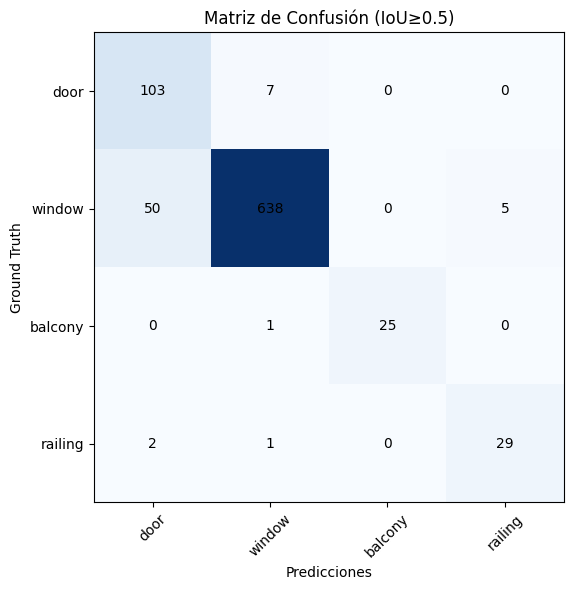

In [61]:
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from torchvision.ops import box_iou
import numpy as np

def evaluate_detailed_metrics(model, dataset, device, score_threshold=0.5, iou_threshold=0.5, class_names=None):
    """
    Calcula precision/recall/F1 por clase y matriz de confusión para detección de objetos
    usando IoU para emparejar predicciones con ground-truth
    """
    model.eval()
    all_gt_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for img, target in dataset:
            img = img.to(device)
            outputs = model([img])
            pred = outputs[0]

            pred_boxes = pred["boxes"].cpu()
            pred_scores = pred["scores"].cpu()
            pred_labels = pred["labels"].cpu()

            gt_boxes = target["boxes"].cpu()
            gt_labels = target["labels"].cpu()

            # Filtrar predicciones por score threshold
            keep = pred_scores > score_threshold
            pred_boxes = pred_boxes[keep]
            pred_scores = pred_scores[keep]
            pred_labels = pred_labels[keep]

            if len(gt_boxes) == 0 or len(pred_boxes) == 0:
                continue

            # Calcular IoU matrix
            iou_matrix = box_iou(pred_boxes, gt_boxes)

            # Para cada GT, encontrar mejor predicción (mayor IoU)
            max_iou_per_gt, max_pred_idx = iou_matrix.max(dim=0)

            for gt_idx in range(len(gt_boxes)):
                best_iou = max_iou_per_gt[gt_idx]
                best_pred_idx = max_pred_idx[gt_idx]

                if best_iou >= iou_threshold:
                    # Match válido: usar label de la predicción
                    gt_label = int(gt_labels[gt_idx].item() - 1)  # 1-4 → 0-3
                    pred_label = int(pred_labels[best_pred_idx].item() - 1)

                    all_gt_labels.append(gt_label)
                    all_pred_labels.append(pred_label)
                else:
                    # GT no detectado (False Negative): no añadir (se maneja con recall)
                    pass

    if len(all_gt_labels) == 0:
        print("No se encontraron matches válidos")
        return None

    # Calcular métricas
    labels = list(range(len(class_names)))
    precision, recall, f1, support = precision_recall_fscore_support(
        all_gt_labels, all_pred_labels,
        labels=labels, zero_division=0, average=None
    )

    cm = confusion_matrix(all_gt_labels, all_pred_labels, labels=labels)

    results = {
        "precision": dict(zip(class_names, precision)),
        "recall": dict(zip(class_names, recall)),
        "f1": dict(zip(class_names, f1)),
        "support": dict(zip(class_names, support)),  # número de GT por clase
        "confusion_matrix": cm.tolist(),
        "total_matches": len(all_gt_labels)
    }

    return results

# USO:
class_names = ["door", "window", "balcony", "railing"]
results = evaluate_detailed_metrics(
    model, val_dataset, DEVICE,
    score_threshold=0.5,
    iou_threshold=0.5,
    class_names=class_names
)

if results:
    print("=== MÉTRICAS POR CLASE ===")
    for cls, prec, rec, f1 in zip(
        class_names,
        results["precision"].values(),
        results["recall"].values(),
        results["f1"].values()
    ):
        print(f"{cls:10}: P={prec:.3f}, R={rec:.3f}, F1={f1:.3f}")

    print(f"\nTotal matches procesados: {results['total_matches']}")

    # Matriz de confusión
    import matplotlib.pyplot as plt
    cm = np.array(results["confusion_matrix"])
    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap='Blues')
    plt.title('Matriz de Confusión (IoU≥0.5)')
    plt.xlabel('Predicciones')
    plt.ylabel('Ground Truth')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(j, i, cm[i,j], ha='center', va='center')
    plt.tight_layout()
    plt.show()


In [63]:
import os
import json
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Mejores hiperparámetros del trial 1
BEST_PARAMS = {
    "lr": 0.0010409383770518521,
    "weight_decay": 7.683590751969013e-05,
    "optimizer": "Adam"
}

# Carpeta para guardar checkpoints y métricas
EXPERIMENT_DIR = "best_trial_training"
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=0,
    pin_memory=False
)


model = fasterrcnn_mobilenet_v3_large_fpn(
    weights="DEFAULT",
    min_size=512,
    max_size=800
)

# Congelar TODO el backbone
for p in model.backbone.parameters():
    p.requires_grad = False

# Reemplazar box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,
    NUM_CLASSES
)

model.to(DEVICE)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = (
    torch.optim.Adam(params, lr=BEST_PARAMS["lr"], weight_decay=BEST_PARAMS["weight_decay"])
    if BEST_PARAMS["optimizer"] == "Adam"
    else torch.optim.AdamW(params, lr=BEST_PARAMS["lr"], weight_decay=BEST_PARAMS["weight_decay"])
)


EPOCHS = 15 
epoch_losses = []

for epoch in range(1, EPOCHS + 1):
    print(f"\n===== EPOCH {epoch}/{EPOCHS} =====")
    model.train()
    total_loss = 0.0

    for batch_i, (imgs, targets) in enumerate(train_loader):
        print(f"Batch {batch_i+1}/{len(train_loader)}")

        imgs = [img.to(DEVICE) for img in imgs]

        targets = [
            {"boxes": t["boxes"].to(DEVICE).float(),
             "labels": t["labels"].to(DEVICE).long()}
            for t in targets
        ]

        optimizer.zero_grad(set_to_none=True)
        output = model(imgs, targets)
        if isinstance(output, list):
            raise RuntimeError(
                "El modelo devolvió predicciones en vez de pérdidas. Revisa los targets."
            )

        loss = sum(output.values())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        del imgs, targets, output, loss

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Average loss epoch {epoch}: {avg_loss:.4f}")

    
    if epoch % 2 == 0:
        from torchmetrics.detection.mean_ap import MeanAveragePrecision

        def compute_map_coco(model, data_loader, device):
            model.eval()
            metric = MeanAveragePrecision(iou_type="bbox")
            with torch.no_grad():
                for imgs, targets in data_loader:
                    imgs = [img.to(device) for img in imgs]
                    outputs = model(imgs)

                    preds = []
                    gts = []

                    for o, t in zip(outputs, targets):
                        preds.append({
                            "boxes": o["boxes"].detach().cpu(),
                            "scores": o["scores"].detach().cpu(),
                            "labels": o["labels"].detach().cpu(),
                        })
                        gts.append({
                            "boxes": t["boxes"].detach().cpu(),
                            "labels": t["labels"].detach().cpu(),
                        })

                    metric.update(preds, gts)

            result = metric.compute()
            return {
                "map50": result["map_50"].item(),
                "map50_95": result["map"].item(),
                "map_per_class": result["map_per_class"].tolist()
            }

        metrics = compute_map_coco(model, val_loader, DEVICE)
        print(f"DEBUG Epoch {epoch}: map50={metrics['map50']:.4f}, map50_95={metrics['map50_95']:.4f}")


with open(os.path.join(EXPERIMENT_DIR, "losses.json"), "w") as f:
    json.dump(epoch_losses, f, indent=4)

metrics = compute_map_coco(model, val_loader, DEVICE)
with open(os.path.join(EXPERIMENT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=4)

torch.save(model.state_dict(), os.path.join(EXPERIMENT_DIR, "model.pth"))

print(f"\nEntrenamiento completado. Último mAP: map50={metrics['map50']:.4f}, map50_95={metrics['map50_95']:.4f}")



===== EPOCH 1/15 =====
Batch 1/1943
Batch 2/1943
Batch 3/1943
Batch 4/1943
Batch 5/1943
Batch 6/1943
Batch 7/1943
Batch 8/1943
Batch 9/1943
Batch 10/1943
Batch 11/1943
Batch 12/1943
Batch 13/1943
Batch 14/1943
Batch 15/1943
Batch 16/1943
Batch 17/1943
Batch 18/1943
Batch 19/1943
Batch 20/1943
Batch 21/1943
Batch 22/1943
Batch 23/1943
Batch 24/1943
Batch 25/1943
Batch 26/1943
Batch 27/1943
Batch 28/1943
Batch 29/1943
Batch 30/1943
Batch 31/1943
Batch 32/1943
Batch 33/1943
Batch 34/1943
Batch 35/1943
Batch 36/1943
Batch 37/1943
Batch 38/1943
Batch 39/1943
Batch 40/1943
Batch 41/1943
Batch 42/1943
Batch 43/1943
Batch 44/1943
Batch 45/1943
Batch 46/1943
Batch 47/1943
Batch 48/1943
Batch 49/1943
Batch 50/1943
Batch 51/1943
Batch 52/1943
Batch 53/1943
Batch 54/1943
Batch 55/1943
Batch 56/1943
Batch 57/1943
Batch 58/1943
Batch 59/1943
Batch 60/1943
Batch 61/1943
Batch 62/1943
Batch 63/1943
Batch 64/1943
Batch 65/1943
Batch 66/1943
Batch 67/1943
Batch 68/1943
Batch 69/1943
Batch 70/1943
Batch

In [66]:
import os
import json
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Asumiendo que ya tienes tu dataset cargado
# train_dataset = ...
# val_dataset = ...
# DEVICE = "cuda" o "cpu"
# NUM_CLASSES = número de clases incluyendo fondo

# Mejores hiperparámetros del trial 1
BEST_PARAMS = {
    "lr": 0.0010409383770518521,
    "weight_decay": 7.683590751969013e-05,
    "optimizer": "Adam"
}

# Carpeta para guardar checkpoints y métricas
EXPERIMENT_DIR = "best_trial_training_2"
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=0,
    pin_memory=False
)

# =========================
# MODELO
# =========================
model = fasterrcnn_mobilenet_v3_large_fpn(
    weights="DEFAULT",
    min_size=512,
    max_size=800
)

# Congelar TODO el backbone
for p in model.backbone.parameters():
    p.requires_grad = False

# Reemplazar box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,
    NUM_CLASSES
)

model.to(DEVICE)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = (
    torch.optim.Adam(params, lr=BEST_PARAMS["lr"], weight_decay=BEST_PARAMS["weight_decay"])
    if BEST_PARAMS["optimizer"] == "Adam"
    else torch.optim.AdamW(params, lr=BEST_PARAMS["lr"], weight_decay=BEST_PARAMS["weight_decay"])
)

# =========================
# ENTRENAMIENTO
# =========================
EPOCHS = 25 # puedes poner 15 y ver resultados
epoch_losses = []

for epoch in range(1, EPOCHS + 1):
    print(f"\n===== EPOCH {epoch}/{EPOCHS} =====")
    model.train()
    total_loss = 0.0

    for batch_i, (imgs, targets) in enumerate(train_loader):
        print(f"Batch {batch_i+1}/{len(train_loader)}")

        imgs = [img.to(DEVICE) for img in imgs]

        targets = [
            {"boxes": t["boxes"].to(DEVICE).float(),
             "labels": t["labels"].to(DEVICE).long()}
            for t in targets
        ]

        optimizer.zero_grad(set_to_none=True)
        output = model(imgs, targets)
        if isinstance(output, list):
            raise RuntimeError(
                "El modelo devolvió predicciones en vez de pérdidas. Revisa los targets."
            )

        loss = sum(output.values())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        del imgs, targets, output, loss

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Average loss epoch {epoch}: {avg_loss:.4f}")

    # =========================
    # EVALUAR mAP cada 2 epochs
    # =========================
    if epoch % 2 == 0:
        from torchmetrics.detection.mean_ap import MeanAveragePrecision

        def compute_map_coco(model, data_loader, device):
            model.eval()
            metric = MeanAveragePrecision(iou_type="bbox")
            with torch.no_grad():
                for imgs, targets in data_loader:
                    imgs = [img.to(device) for img in imgs]
                    outputs = model(imgs)

                    preds = []
                    gts = []

                    for o, t in zip(outputs, targets):
                        preds.append({
                            "boxes": o["boxes"].detach().cpu(),
                            "scores": o["scores"].detach().cpu(),
                            "labels": o["labels"].detach().cpu(),
                        })
                        gts.append({
                            "boxes": t["boxes"].detach().cpu(),
                            "labels": t["labels"].detach().cpu(),
                        })

                    metric.update(preds, gts)

            result = metric.compute()
            return {
                "map50": result["map_50"].item(),
                "map50_95": result["map"].item(),
                "map_per_class": result["map_per_class"].tolist()
            }

        metrics = compute_map_coco(model, val_loader, DEVICE)
        print(f"DEBUG Epoch {epoch}: map50={metrics['map50']:.4f}, map50_95={metrics['map50_95']:.4f}")

# =========================
# GUARDAR MODELO Y METRICAS
# =========================
with open(os.path.join(EXPERIMENT_DIR, "losses.json"), "w") as f:
    json.dump(epoch_losses, f, indent=4)

metrics = compute_map_coco(model, val_loader, DEVICE)
with open(os.path.join(EXPERIMENT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=4)

torch.save(model.state_dict(), os.path.join(EXPERIMENT_DIR, "model.pth"))

print(f"\nEntrenamiento completado. Último mAP: map50={metrics['map50']:.4f}, map50_95={metrics['map50_95']:.4f}")



===== EPOCH 1/25 =====
Batch 1/1943
Batch 2/1943
Batch 3/1943
Batch 4/1943
Batch 5/1943
Batch 6/1943
Batch 7/1943
Batch 8/1943
Batch 9/1943
Batch 10/1943
Batch 11/1943
Batch 12/1943
Batch 13/1943
Batch 14/1943
Batch 15/1943
Batch 16/1943
Batch 17/1943
Batch 18/1943
Batch 19/1943
Batch 20/1943
Batch 21/1943
Batch 22/1943
Batch 23/1943
Batch 24/1943
Batch 25/1943
Batch 26/1943
Batch 27/1943
Batch 28/1943
Batch 29/1943
Batch 30/1943
Batch 31/1943
Batch 32/1943
Batch 33/1943
Batch 34/1943
Batch 35/1943
Batch 36/1943
Batch 37/1943
Batch 38/1943
Batch 39/1943
Batch 40/1943
Batch 41/1943
Batch 42/1943
Batch 43/1943
Batch 44/1943
Batch 45/1943
Batch 46/1943
Batch 47/1943
Batch 48/1943
Batch 49/1943
Batch 50/1943
Batch 51/1943
Batch 52/1943
Batch 53/1943
Batch 54/1943
Batch 55/1943
Batch 56/1943
Batch 57/1943
Batch 58/1943
Batch 59/1943
Batch 60/1943
Batch 61/1943
Batch 62/1943
Batch 63/1943
Batch 64/1943
Batch 65/1943
Batch 66/1943
Batch 67/1943
Batch 68/1943
Batch 69/1943
Batch 70/1943
Batch

In [76]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


NUM_CLASSES = 5  
MODEL_PATH = "/kaggle/working/best_trial_training_2/model.pth"


val_loader = DataLoader(
    val_dataset,
    batch_size=1,  
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)


model = fasterrcnn_mobilenet_v3_large_fpn(
    weights=None,  # sin pesos preentrenados, porque los cargamos
    min_size=512,
    max_size=800
)

# Reemplazar box predictor para el número correcto de clases
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,
    NUM_CLASSES
)

# Cargar pesos entrenados
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

# Pasar a device y modo evaluación
model.to(DEVICE)
model.eval()

metrics = compute_map_coco(model, val_loader, DEVICE)

map50 = metrics["map50"]
map50_95 = metrics["map50_95"]

print(f"Validation set - mAP@0.5: {map50:.4f}")
print(f"Validation set - mAP@0.5:0.95: {map50_95:.4f}\n")


Validation set - mAP@0.5: 0.3286
Validation set - mAP@0.5:0.95: 0.1497



In [79]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


NUM_CLASSES = 5  
MODEL_PATH = "/kaggle/working/best_trial_training_2/model.pth"

TEST_IMG_DIR = "/kaggle/input/test-completo/test/images" 
TEST_LBL_DIR = "/kaggle/input/test-completo/test/labels"  
IMG_SIZE = 512


test_dataset = PreloadedDataset(
    img_dir=TEST_IMG_DIR,
    lbl_dir=TEST_LBL_DIR,
    img_size=IMG_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)


model = fasterrcnn_mobilenet_v3_large_fpn(
    weights=None,
    min_size=512,
    max_size=800
)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,
    NUM_CLASSES
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


metrics = compute_map_coco(model, test_loader, DEVICE)

map50 = metrics["map50"]
map50_95 = metrics["map50_95"]

print(f"Test set - mAP@0.5: {map50:.4f}")
print(f"Test set - mAP@0.5:0.95: {map50_95:.4f}\n")


Test set - mAP@0.5: 0.2939
Test set - mAP@0.5:0.95: 0.1253

